1. (Advertiser 유사도 계산을 통해) 유저가 클릭한 광고주와 가장 유사도 높은 광고주 추천  
2. 광고주별로 count 찍고 top-k 명 추천 (aka 오늘의 인기 상점)
3. NLP를 통해 게시글 제목 분석 후 유사도 계산

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/data/ad.zip (Unzipped Files)/data/'

ad = pd.read_csv(data_path + 'ad.csv')
advertiser = pd.read_csv(data_path + 'advertiser.csv')
# dataset = pd.read_csv(data_path + 'dataset.csv')
# impression_log = pd.read_csv(data_path + 'impression_log.csv')
# view_log = pd.read_csv(data_path + 'view_log.csv')
# viewer = pd.read_csv(data_path + 'viewer.csv')

In [ ]:
# user-advertiser matrix를 만들 때 쓰였던 df
temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ad.zip (Unzipped Files)/data/groupby.csv')
temp = temp.drop('Unnamed: 0', axis = 1)
temp

,imp_id,server_time_kst,bid_price,device_type,content_id,viewer_id,advertizer_id
0,99d1612dded122458e99,2021-08-31T16:56:46.013+09:00,50,a,137078818,1728109,12851816
1,998c612ddab9008cceee,2021-08-31T16:32:01.533+09:00,385,a,132419409,77328955,66620
2,998c612dd77f007f2d67,2021-08-31T16:17:26.423+09:00,50,a,162053601,75559871,2701783
3,971a612ddff00eb50a47,2021-08-31T16:53:48.436+09:00,70,a,161384072,9461170,12851816
4,971a612ddd140ea93f30,2021-08-31T16:41:29.857+09:00,155,a,162732366,10809468,9592612
...,...,...,...,...,...,...,...
25593,97f9612d19ad146e7af3,2021-08-31T02:48:14.302+09:00,230,a,156270703,3730768,4421086
25594,97f9612d1250145c2e00,2021-08-31T02:16:06.295+09:00,60,a,162188680,13008046,201368
25595,99d1612d19e220565606,2021-08-31T02:48:24.894+09:00,60,a,161297627,76011534,10255755
25596,99d1612d12bf2044dde5,2021-08-31T02:18:03.444+09:00,80,a,142540474,1581224,12851816


# 1. 유저가 클릭한 광고주와 가장 유사도 높은 광고주 추천

* content-based filtering의 가장 큰 장점은 user-item matrix가 필요 없다는 것.
* 광고주 데이터만을 가지고 유저가 클릭한 광고주와 가장 비슷한 광고주 k명을 추천해보자.

In [ ]:
advertiser

,user_id,favorite_count,grade,item_count,interest,review_count,comment_count,follower_count,pay_count,parcel_post_count,transfer_count,chat_count
0,2487730,1899,7673,431,31681,775,529,0,575,0,35,130
1,1462217,799,5520,433,16794,570,250,0,942,0,57,11
2,6972746,3692,7526,2530,36944,776,828,0,325,0,10,13
3,1358510,1228,2106,100,27142,223,431,0,232,9,1,4
4,1358510,1228,2106,100,27142,223,431,0,232,9,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1534,10255755,2063,7539,784,3424,755,392,0,677,0,5,236
1535,10255755,2063,7539,784,3424,755,392,0,677,0,5,236
1536,10255755,2063,7539,784,3424,755,392,0,677,0,5,236
1537,10255755,2063,7539,784,3424,755,392,0,677,0,5,236


<고민 1>  
* content-based filtering 예제와 우리 데이터의 차이점  
    * 우리의 데이터는 일반적인 content-based filtering의 예제(사진)와 다르게 one-hot encoding/tf-idf 할 수 없는  feature로 구성되어 있음  
= 다른말로 하면 우리 데이터의 feature는 discrete(categorical)하지 않고 continuous 함
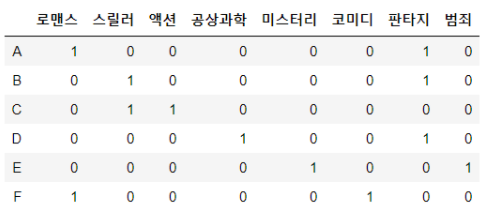  
* 그냥 사이킷런 모듈을 이용해서 advertiser 간의 유사도를 구하는 방식으로 진행

<고민2>
* feature extraction  
    * 평균 좋아요 수 (favorite count/item count) 등의 feature를 추가해서 유사도를 계산하면 성능이 더 좋아지지 않을까
    

In [ ]:
# advertiser dataset 내 광고주 id 중복 값 확인
advertiser.user_id.value_counts()

12851816    146
10255755    104
10197556     92
3947717      73
2347538      52
           ... 
4380220       1
6549054       1
76568156      1
10055910      1
9462379       1
Name: user_id, Length: 372, dtype: int64

In [ ]:
# 모든 column의 값이 똑같은 것으로 보아 완전한 중복 값이므로 drop해도 무방하다고 판단
advertiser[advertiser['user_id'] == 12851816]

,user_id,favorite_count,grade,item_count,interest,review_count,comment_count,follower_count,pay_count,parcel_post_count,transfer_count,chat_count
514,12851816,2131,5285,247,4525,542,739,0,496,0,0,11
515,12851816,2131,5285,247,4525,542,739,0,496,0,0,11
516,12851816,2131,5285,247,4525,542,739,0,496,0,0,11
517,12851816,2131,5285,247,4525,542,739,0,496,0,0,11
518,12851816,2131,5285,247,4525,542,739,0,496,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...
1226,12851816,2131,5285,247,4525,542,739,0,496,0,0,11
1227,12851816,2131,5285,247,4525,542,739,0,496,0,0,11
1228,12851816,2131,5285,247,4525,542,739,0,496,0,0,11
1229,12851816,2131,5285,247,4525,542,739,0,496,0,0,11


* 광고주 id (user_id)에 중복 값이 많이 있다.
* 광고주 간의 유사도를 계산하기 위해 중복값을 drop 하자.

In [ ]:
print(f'중복 값 제거 전 : {advertiser.shape}')
advertiser.drop_duplicates(inplace = True)
print(f'중복 값 제거 후 : {advertiser.shape}')

중복 값 제거 전 : (1539, 12)
중복 값 제거 후 : (372, 12)


* 데이터가 굉장히 홀쭉해졌다.

In [ ]:
# 유사도 계산을 위해 index를 advertiser의 id (user_Id)로 바꾸자
advertiser.set_index('user_id', drop = True, inplace = True)
advertiser.head()

,favorite_count,grade,item_count,interest,review_count,comment_count,follower_count,pay_count,parcel_post_count,transfer_count,chat_count
user_id,,,,,,,,,,,
2487730,1899,7673,431,31681,775,529,0,575,0,35,130
1462217,799,5520,433,16794,570,250,0,942,0,57,11
6972746,3692,7526,2530,36944,776,828,0,325,0,10,13
1358510,1228,2106,100,27142,223,431,0,232,9,1,4
5051200,254,692,77,6462,74,0,0,196,8,40,0


In [ ]:
# 이를 기반으로 광고주간의 유사도를 구해보자.
advertiser_cos = cosine_similarity(advertiser, advertiser)
print(advertiser_cos.shape)
advertiser_cos

(372, 372)


array([[1.        , 0.99599938, 0.99706301, ..., 0.85711839, 0.5216213 ,
        0.56969565],
       [0.99599938, 1.        , 0.98992976, ..., 0.86830298, 0.58797835,
        0.56476098],
       [0.99706301, 0.98992976, 1.        , ..., 0.87927369, 0.50348475,
        0.61818909],
       ...,
       [0.85711839, 0.86830298, 0.87927369, ..., 1.        , 0.639017  ,
        0.86044099],
       [0.5216213 , 0.58797835, 0.50348475, ..., 0.639017  , 1.        ,
        0.35022026],
       [0.56969565, 0.56476098, 0.61818909, ..., 0.86044099, 0.35022026,
        1.        ]])

* 자기 자신과의 유사도가 1이고 matrix 사이즈가 (372 x 372)인 것으로 보아 잘 만들어진 것 같다.

In [ ]:
# 추천에 필요한 광고주 index를 따로 만들어야 하기 때문에 index를 초기화해준다.
advertiser.reset_index(inplace = True)
advertiser

,index,user_id,favorite_count,grade,item_count,interest,review_count,comment_count,follower_count,pay_count,parcel_post_count,transfer_count,chat_count
0,0,2487730,1899,7673,431,31681,775,529,0,575,0,35,130
1,1,1462217,799,5520,433,16794,570,250,0,942,0,57,11
2,2,6972746,3692,7526,2530,36944,776,828,0,325,0,10,13
3,3,1358510,1228,2106,100,27142,223,431,0,232,9,1,4
4,4,5051200,254,692,77,6462,74,0,0,196,8,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,367,75231266,28,38,193,69,5,0,0,11,1,0,2
368,368,5332936,2,51,12,289,5,1,0,1,0,0,0
369,369,8173665,4,10,16,26,1,5,0,2,0,0,0
370,370,2294187,462,3720,833,1228,376,0,0,186,1,6,60


In [ ]:
# 광고주와 광고주의 index의 조합을 따로 기억해두자. (이 index를 통해 광고주간의 유사도를 slicing 해옴.)
indices = pd.Series(advertiser.index, index = advertiser['user_id'])
indices

user_id
2487730       0
1462217       1
6972746       2
1358510       3
5051200       4
           ... 
75231266    367
5332936     368
8173665     369
2294187     370
74805836    371
Length: 372, dtype: int64

In [ ]:
line = '-----------------------------------------------------------------------'
sharp = '#######################################################################'

In [ ]:
# 광고주의 id를 입력으로 받아서 유사한 광고주 10명을 추천하는 로직

def get_rec_with_advertiserID(advertiser_id, cosine_sim = advertiser_cos):

    # 1. 추천의 기준이 되는 광고주의 인덱스를 가져와서
    idx = indices[advertiser_id] 

    # 2. input에 해당하는 광고주의 유사도를 가져온다. (만약 5051200(advertiser_id)를 input으로 줬으면 -> sim_scores에는 5051200광고주에 관한 모든 광고주의 유사도가 list로 존재하게 됨.)
    sim_scores = list(enumerate(cosine_sim[idx]))  

    # 3. 유사도를 내림차순 정렬한다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) 
    
    # 4. 상위 10개만 자른다. (top-k = 10)
    sim_scores = sim_scores[1:11] 

    # 5. 유사도 top-10에 해당하는 광고주의 index를 가져온다. (이걸로 광고주 id를 slicing)
    advertiser_indices = [i[0] for i in sim_scores]  

    # 예시 멘트
    print('이런 상점은 어때요?')
    print(f'[{advertiser_id}] 님과 가장 유사한 상점 10곳이에요.')

    # 6.추천
    return print(advertiser['user_id'].iloc[advertiser_indices]), print(line)

In [ ]:
# 추천해보자
get_rec_with_advertiserID(1358510)

이런 상점은 어때요?
[1358510] 님과 가장 유사한 상점 10곳이에요.
289     948674
236      66620
259    2250054
222    3394365
341     541227
5       969061
366    1933344
97      266981
78      906947
212    2570676
Name: user_id, dtype: int64
-----------------------------------------------------------------------


(None, None)

* 광고주의 id를 입력했을 때 유사도가 가장 높은 10명의 광고주 리스트를 가져와진 것을 알 수 있음.
* 왼쪽이 광고주의 index, 오른쪽이 광고주의 id
* 활용 방안
    * 이 로직은 유저가 광고(우리의 메인 모델의 추천 결과)를 클릭했을 때 UI에 *'이런 상점은 어때요?'*를 만들어서 *비슷한 광고주 추천하는 방식*으로 활용 가능할 것 같다.  
 (클릭된 광고를 이용해 다른 상점을 또 추천(광고)를 할 수 있다. 첫 추천에 유저의 취향이 잘 반영 되었다면, 클릭된 광고와 비슷한 상점을 잘 추천해주었을 때 또 클릭될 확률이 높을 것)

In [ ]:
# 1358510 광고주를 예시로 얼마나 유사한 광고주가 추천되었는지 보자. (눈바디)

advertiser[advertiser['user_id'] == 1358510] 

,user_id,favorite_count,grade,item_count,interest,review_count,comment_count,follower_count,pay_count,parcel_post_count,transfer_count,chat_count
3,1358510,1228,2106,100,27142,223,431,0,232,9,1,4


In [ ]:
advertiser[advertiser['user_id'] == 948674] # 1등으로 추천된 유저

,user_id,favorite_count,grade,item_count,interest,review_count,comment_count,follower_count,pay_count,parcel_post_count,transfer_count,chat_count
289,948674,10504,19027,44,260464,1969,4069,0,172,0,1,17


In [ ]:
advertiser[advertiser['user_id'] == 66620] # 2등으로 추천된 유저

,user_id,favorite_count,grade,item_count,interest,review_count,comment_count,follower_count,pay_count,parcel_post_count,transfer_count,chat_count
236,66620,3092,8067,131,92447,822,2495,0,752,0,0,23


* 추천 결과를 보니 추천의 기준이 되는 광고주와 추천된 광고주 사이에 유사해보이는 구석이 별로 없다.
* 원인
    * 비교 대상이 너무 적기 때문 (광고주 수 372명)
    * 유사도 계산에 사용된 feature가 유의미하지 않아서 (게시글 제목, 키워드, 카테고리 등의 주요 항목이 고려 x)
* 성능 개선 방안 2 가지
    1. n 가지 방식으로 유사도를 계산 후 이를 평균낸 값을 최종 유사도로 사용한다. (NLP로 게시글 제목 간의 유사도를 계산한다던지..)
    2. 추가적인 feature extraction을 통해 feature를 늘린 후 유사도를 다시 계산한다. (광고주 게시글의 제목, 카테고리, 키워드 등을 활용)
    3. 1,2번을 둘 다 한다.

In [ ]:
# (응용) 광고주 id 말고 유저 id를 입력으로 받아와서 추천해보자.
# viewer_id 입력 -> viewer가 본 광고 -> 해당 광고의 광고주 -> 광고주와 비슷한 광고주 추천

def get_rec_with_viewerID(viewer_id):
    
    # 1. viewer가 여러 광고주의 광고를 보는 경우가 있기 때문에 유저가 본 광고주 목록을 담을 빈 list를 만든다.
    adv_list = []   

    # 2. viewer가 본 광고의 광고주를 list에 담는다. (drop_duplicates : 같은 광고를 여러번 본 경우 중복 추천을 방지하기 위해)
    for i  in temp[temp['viewer_id'] == viewer_id].advertizer_id.drop_duplicates(): 
        adv_list.append(i)

    print(sharp)
    print('#', viewer_id, '님이 본 광고의 광고주는', adv_list, '입니다.#')
    print(sharp)
    print('\n')

    # 3. 위에서와 동일하게 advertiser_id를 이용해 높은 유사도의 광고주를 추천.
    for advertiser in adv_list:
        get_rec_with_advertiserID(advertiser)  # 추천은 여전히 광고주 id를 이용. 그저 광고주 id 입력을 직접하는지 viewer_id를 통해 가져오는지의 차이.
                                               

In [ ]:
get_rec_with_viewerID(1728109)

#######################################################################
# 1728109 님이 본 광고의 광고주는 [12851816, 10197556, 948674] 입니다.#
#######################################################################


이런 상점은 어때요?
[12851816] 님과 가장 유사한 상점 10곳이에요.
345     8266205
353     9240746
100      178506
127     1753950
6       9698825
14      2347538
255    11951839
90      1909021
113    12211204
294    10255755
Name: user_id, dtype: int64
-----------------------------------------------------------------------
이런 상점은 어때요?
[10197556] 님과 가장 유사한 상점 10곳이에요.
294    10255755
293     6011124
29     10934396
305     1286544
348    74912330
271     2727955
264     7917201
93     11484675
87       970589
71      9464815
Name: user_id, dtype: int64
-----------------------------------------------------------------------
이런 상점은 어때요?
[948674] 님과 가장 유사한 상점 10곳이에요.
3      1358510
222    3394365
259    2250054
236      66620
97      266981
366    1933344
341     541227
78      906947
322    2378665
5       96

still to come
* loss 계산은 어떻게 해야할까?  
    * cosine distance(1-cosine similarity)의 합?  
    -> top-k recommendation은 유사한 정도(점수)가 아닌 순서가 중요한 것.  
    (유사한 정도를 loss로 잡으면 안 될 지도...(유사한 광고주가 없다면 그나마 비슷한 광고주라도 추천해줘야하니까))

# 2. 광수님 의견

In [ ]:
print(sharp)
print('###################### 8월 31일 best 상점 top-10 ######################')
print(sharp)

top_10_merchant = pd.DataFrame(temp.groupby('advertizer_id')['imp_id'].count().sort_values(ascending = False).head(10)) # temp = 전에 viewer-advertiser matix 만들 때 쓴 groupby dataframe
top_10_merchant.rename(columns = {'imp_id' : 'score'}, inplace = True) # imp_id count 수를 score로 변경

print(top_10_merchant)
print('\n')

# for advertiser in list(top_10_merchant.index.values):
#     print(get_rec_with_advertiserID(advertiser))

#######################################################################
###################### 8월 31일 best 상점 top-10 ######################
#######################################################################
               score
advertizer_id       
12211204        3067
12851816        2897
3947717         2357
10197556        1590
10255755        1543
201368          1373
76633207         881
3682152          726
6972746          720
2347538          711




* 정확히 말하면 '광고된 상점' 중 best 상점인 것.
* 번장 관계자님 : 유저에게 광고주를 추천해준다고 그랬는데, 취향에 대한 정보가 없는 신규 유저에게 추천해줄 때는 어떻게 하실건가요? (cold start problem)  
    => 범용성이 높은 금일 베스트 상점 top-10개를 추천해주어서 취향 정보를 알아내겠다.
* 활용 방안  
    * 오늘의 베스트 상점을 추천 -> 유저가 클릭하면 해당 best 상점과 유사도가 높은 상점을 또 추천한다.

# 3. 결론
<content-based filtering의 메인 모델로서의 가치>
* 메인 모델로서의 가치는 낮아 보임.
* 다만, 메인 모델에 서브로 탑재하거나 메인 모델의 부족한 부분(cold-start problem)을 보완하는 수단으로 활용이 가능해보임.

<보완점>
* loss 계산 및 학습은 어떻게 할지 고민이 필요
* 모델이 너무 심플하다.